# Working with Excel Cells

We can work with Excel file at cell level using `openpyxl` and `xlwings`.

In [1]:
!pip install openpyxl

## 1. Update Excel Cells

### Prepare a Sample Excel File

In [2]:
import pandas as pd
import numpy as np

In [3]:
n = np.arange(12).reshape(3,4)
df = pd.DataFrame(n, columns=list('ABCD'), index=list('abc'))
df

,A,B,C,D
a,0,1,2,3
b,4,5,6,7
c,8,9,10,11


Save to Excel with header row and index column.

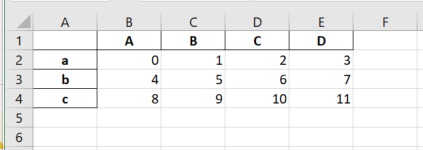

Remove existing file `test.xlsx`. 

In [4]:
import os

if os.path.exists('test.xlsx'):
    os.remove('test.xlsx')

Save dataframe to excel file `test.xlsx`. Read to verify that the data is saved correctly.

In [5]:
df.to_excel('test.xlsx', index=False)
pd.read_excel('test.xlsx')

,A,B,C,D
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11


### Update Cells in Excel File

You can create a new workbook or open an existing workbook. 

In [6]:
import openpyxl

## To create a new workbook
# wb = openpyxl.Workbook()
## Or to open an existing workbook
wb = openpyxl.load_workbook('test.xlsx')

With worksheet, you can read individual cells.

In [7]:
ws = wb['Sheet1']
cell1 = ws['A4']
print(cell1.value)
cell2 = ws.cell(row=3, column=1)
print(cell2.value)

8
4


You can also set value for some cells.

In [8]:
ws.cell(row=1,column=5).value = 'E'
ws['E2']= 91
ws['E3']= 92

wb.save('test.xlsx')
wb.close()

Verify the values in the worksheet.

In [9]:
pd.read_excel('test.xlsx')

,A,B,C,D,E
0,0,1,2,3,91.0
1,4,5,6,7,92.0
2,8,9,10,11,NaN


## 2. Set Formula with `openpyxl`

Write the formula to cells.

In [17]:
import openpyxl
wb = openpyxl.load_workbook('test.xlsx')
ws = wb['Sheet1']

ws["E1"] = "SUM"
for i in range(2,5):
    ws[f"E{i}"] = f"=SUM(A{i}:D{i})"

wb.save('test.xlsx')
wb.close()

Read the Excel using pandas.

In [18]:
pd.read_excel('test.xlsx')

,A,B,C,D,SUM
0,0,1,2,3,NaN
1,4,5,6,7,NaN
2,8,9,10,11,NaN


Why the value is `NaN`? It shows that the formula is not evaluated.
* The formula will only be evaluated when Excel file is open

### Evaluate Formula

Instead of opening Excel file manually to trigger evaluation of formula, we can use `xlwings` to simulate opening of Excel file.

In [12]:
!pip install xlwings

Define a function to do the job.
* It opens the file in the background, which triggers evaluation of formula.
* It saves the file and closes itself.

In [13]:
def eval_excel_formula(filename):
    import xlwings as xw
    app = xw.App(visible=False)
    wbook = app.books.open(filename)
    wbook.save()
    wbook.close()
    app.quit()

In [14]:
eval_excel_formula('test.xlsx')

Read the excel again using `openpyxl`.

In [15]:
wb = openpyxl.load_workbook('test.xlsx', data_only = True)
ws = wb['Sheet1']
df = pd.DataFrame(ws.values)
print(df)

for value in ws.iter_rows(min_row=1,
                              max_row=4,
                              min_col=1,
                              max_col=5,
                              values_only=True):
    print(value)

wb.close()

   0  1   2   3    4
0  A  B   C   D  SUM
1  0  1   2   3    6
2  4  5   6   7   22
3  8  9  10  11   38
('A', 'B', 'C', 'D', 'SUM')
(0, 1, 2, 3, 6)
(4, 5, 6, 7, 22)
(8, 9, 10, 11, 38)


Without specifying parameter `data_only = True`, it will read the formula.

In [16]:
import openpyxl
wb = openpyxl.load_workbook('test.xlsx')
ws = wb['Sheet1']

df = pd.DataFrame(ws.values)
# Set first row as header
column_names = df.iloc[0] 
df = df[1:] 
df.columns = column_names
print(df)

wb.close()

0  A  B   C   D          SUM
1  0  1   2   3  =SUM(A2:D2)
2  4  5   6   7  =SUM(A3:D3)
3  8  9  10  11  =SUM(A4:D4)
